[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/OBP_2025/blob/main/analysis_notebooks/bulk_multimapping.ipynb)

# Clone Github Repo

In [ ]:
!git clone https://github.com/pachterlab/OBP_2025.git
%cd /content/OBP_2025/

In [ ]:
!pip install -qr requirements.txt

In [ ]:
# import packages

import os, sys
sys.path.append('../')
from pathlib import Path

import time

# numbers
import numpy as np
import pandas as pd

import anndata

# plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [4]:
def gtf2df(gtf: str, sep_type = '1') -> pd.DataFrame:
    """
    Convert a GTF file to a pandas DataFrame.
    Tested with Ensemble GTF files.
    Parameters
    ----------
    gtf : str
        Path to the GTF file.
    Returns
    -------
    df : pandas.DataFrame
    Examples
    --------
    .. highlight:: python
    .. code-block:: python
        df = gtf2df('ensembl.gtf')
        df.head()
    """

    df = pd.read_csv(gtf, sep='\t', header=None, comment='#')
    df.columns = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']

    fields = ['ID', 'Parent', 'Dbxref', 'Name', 'Ontology_term', 'locus_tag', 'old_locus_tag']
    for field in fields:
        if sep_type == '1':
            df[field] = df['attribute'].apply(lambda x: re.findall(f'{field}=([^"]*)', x)[0].split(';')[0] if f'{field}=' in x else '')
        else:
            df[field] = df['attribute'].apply(lambda x: re.findall(f'{field} "*"[^"]*', x)[0].split('"')[1] if f'{field} ' in x else '')

    df.replace('', np.nan, inplace=True)

    df.drop('attribute', axis=1, inplace=True)

    
    return df

In [17]:
normal_gtf = gtf2df('../bulk/references/GCF_000008385.1_ASM838v1_genomic.gff')
normal_gtf

,seqname,source,feature,start,end,score,strand,frame,ID,Parent,Dbxref,Name,Ontology_term,locus_tag,old_locus_tag
0,NC_006833.1,RefSeq,region,1,1080084,.,+,.,NC_006833.1:1..1080084,NaN,taxon:292805,ANONYMOUS,NaN,NaN,NaN
1,NC_006833.1,RefSeq,gene,111,1154,.,+,.,gene-WBM_RS00005,NaN,NaN,hemE,NaN,WBM_RS00005,Wbm0001
2,NC_006833.1,Protein Homology,CDS,111,1154,.,+,0,cds-WP_011256203.1,gene-WBM_RS00005,GenBank:WP_011256203.1,WP_011256203.1,"GO:0006779,GO:0004853",WBM_RS00005,NaN
3,NC_006833.1,RefSeq,gene,1216,2409,.,+,.,gene-WBM_RS00010,NaN,NaN,WBM_RS00010,NaN,WBM_RS00010,Wbm0002
4,NC_006833.1,Protein Homology,CDS,1216,2409,.,+,0,cds-WP_011256204.1,gene-WBM_RS00010,GenBank:WP_011256204.1,WP_011256204.1,"GO:0009058,GO:0008483,GO:0030170",WBM_RS00010,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,NC_006833.1,Protein Homology,CDS,1075864,1077030,.,+,0,cds-WBM_RS04950,gene-WBM_RS04950,NaN,NaN,NaN,WBM_RS04950,NaN
2187,NC_006833.1,RefSeq,gene,1078078,1078299,.,-,.,gene-WBM_RS06685,NaN,NaN,WBM_RS06685,NaN,WBM_RS06685,NaN
2188,NC_006833.1,Protein Homology,CDS,1078078,1078299,.,-,0,cds-WP_083750408.1-6,gene-WBM_RS06685,GenBank:WP_083750408.1,WP_083750408.1,NaN,WBM_RS06685,NaN
2189,NC_006833.1,RefSeq,gene,1078996,1079811,.,-,.,gene-WBM_RS04960,NaN,NaN,WBM_RS04960,NaN,WBM_RS04960,Wbm0809


In [18]:
goi = ['Wbm0647', 'Wbm0648', 'Wbm0649',
      'Wbm0650', 'Wbm0651', 'Wbm0652',
      'WBM_RS03925', 
       'WBM_RS03930', 
       'Wbm0653',
      'WBM_RS03940', 
       'WBM_RS03945' 
    ]

In [23]:
gene_dict = normal_gtf[[x in goi for x in normal_gtf.old_locus_tag]][['ID', 'locus_tag', 'old_locus_tag']]
gene_dict2 = normal_gtf[[x in goi for x in normal_gtf.locus_tag]][['ID', 'locus_tag', 'old_locus_tag']]
gene_dict = pd.concat([gene_dict, gene_dict2])
gene_dict = gene_dict.fillna(0)
gene_dict['locus_tag'] = gene_dict.apply(lambda x: x['locus_tag'] if x['old_locus_tag'] == 0 else x['old_locus_tag'],axis=1)
gene_dict = gene_dict[['ID', 'locus_tag']]
gene_dict = gene_dict.set_index('ID').transpose().to_dict(orient='index')['locus_tag']
# add genes added by fusion

gene_dict['gene-WBM_RS03950'] = 'gene-WBM_RS03950'
gene_dict['rna-WBM_RS05530'] = 'rna-WBM_RS05530'
gene_dict['gene-WBM_RS03935'] = gene_dict['gene-WBM_RS03935'] + '*' 

In [24]:
gene_dict

{'gene-WBM_RS05535': 'Wbm0647',
 'gene-WBM_RS03900': 'Wbm0648',
 'gene-WBM_RS03905': 'Wbm0649',
 'gene-WBM_RS03910': 'Wbm0650',
 'gene-WBM_RS03915': 'Wbm0651',
 'gene-WBM_RS03920': 'Wbm0652',
 'gene-WBM_RS03935': 'Wbm0653*',
 'gene-WBM_RS03925': 'WBM_RS03925',
 'cds-WP_225416108.1': 'WBM_RS03925',
 'gene-WBM_RS03930': 'Wbm7023',
 'rna-WBM_RS03930': 'WBM_RS03930',
 'exon-WBM_RS03930-1': 'WBM_RS03930',
 'gene-WBM_RS03940': 'Wbm7024',
 'rna-WBM_RS03940': 'WBM_RS03940',
 'exon-WBM_RS03940-1': 'WBM_RS03940',
 'gene-WBM_RS03945': 'Wbm7025',
 'rna-WBM_RS03945': 'WBM_RS03945',
 'exon-WBM_RS03945-1': 'WBM_RS03945',
 'gene-WBM_RS03950': 'gene-WBM_RS03950',
 'rna-WBM_RS05530': 'rna-WBM_RS05530'}

## Dataset Loading

In [26]:
file_type = ['default', 'mm'#, 'junction'
            ]
kmer_list = [7, 13, 15, 21, 27, 31]
first=True
for name in file_type:
    for kmer in kmer_list:
        adata = anndata.read_h5ad(f'../bulk/kb_results/test_{kmer}_{name}.h5ad')
        # filter for bacteria genes
        adata = adata[:,['g.' in x or 'r.' in x for x in adata.var.reset_index().gene_id.values]]

        gene_df = adata.var.copy()
        gene_df = gene_df.reset_index()
        gene_df['ID'] = gene_df['gene_id'].str.split('.', expand=True)[1]
        
        gene_df = pd.merge(gene_df, normal_gtf, on = 'ID', how = 'left')
        
        adata.var = gene_df
        adata.var['all_names'] = adata.var[['locus_tag', 'old_locus_tag', 
                                           ]].values.tolist()
        
        adata.var['goi'] = [len(set(x).intersection(goi)) > 0 for x in adata.var.all_names.values]
        
        if first:
            result_df = pd.DataFrame({
                'counts': adata[:,adata.var['goi']].X.toarray().tolist()[0],
                'gene_name': adata[:,adata.var['goi']].var.ID,
                'gene_length': adata[:,adata.var['goi']].var.end - adata[:,adata.var['goi']].var.start
            })
            result_df['gene_name'] = [gene_dict[x] for x in result_df.gene_name.values]
            result_df['source'] = name
            result_df['kmer'] = kmer
            order_df = adata[:,adata.var['goi']].var[['ID','start']]
            first = False
        else:
            if name == 'junction':
                temp_df = pd.DataFrame({
                    'counts': adata[:,adata.var['goi']].X.toarray().tolist()[0],
                    'gene1': adata[:,adata.var['goi']].var.gene1,
                    'gene2': adata[:,adata.var['goi']].var.gene2,
                    'gene1_length': adata[:,adata.var['goi']].var.end_1 - adata[:,adata.var['goi']].var.start_1,
                    'gene2_length': adata[:,adata.var['goi']].var.end_2 - adata[:,adata.var['goi']].var.start_2
                })
                temp_df['gene_length'] = (temp_df['gene1_length'] + temp_df['gene2_length'])/2 #6*kmer #
                temp_df['source'] = name
                temp_df['kmer'] = kmer
                temp_df['gene1'] = temp_df.apply(lambda x: x['gene_name'] if x['gene1'] == 0 else x['gene1'],axis=1)
                temp_df['gene2'] = temp_df.apply(lambda x: x['gene_name'] if x['gene2'] == 0 else x['gene2'],axis=1)
                temp_df['gene1'] = [gene_dict[x] for x in temp_df.gene1.values]
                temp_df['gene2'] = [gene_dict[x] for x in temp_df.gene2.values]
                temp_df['gene_name'] =  temp_df['gene1'] + '-' + temp_df['gene2']
            else:
                temp_df = pd.DataFrame({
                    'counts': adata[:,adata.var['goi']].X.toarray().tolist()[0],
                    'gene_name': adata[:,adata.var['goi']].var.ID,
                    'gene_length': adata[:,adata.var['goi']].var.end - adata[:,adata.var['goi']].var.start
                })
                temp_df['gene_name'] = [gene_dict[x] for x in temp_df.gene_name.values]
                temp_df['source'] = name
                temp_df['kmer'] = kmer
            result_df = pd.concat([result_df, temp_df])
result_df = result_df.fillna(0)
result_df.head(), result_df.shape

/Users/ConradOakes/miniconda3/envs/bac/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/ConradOakes/miniconda3/envs/bac/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/ConradOakes/miniconda3/envs/bac/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/ConradOakes/miniconda3/envs/bac/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/ConradOakes/miniconda3/envs/bac/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/ConradOakes/miniconda3/envs/bac/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transform

(     counts gene_name  gene_length   source  kmer
 841  6730.0   Wbm0647         8519  default     7
 842   150.0   Wbm0648          401  default     7
 843   218.0   Wbm0649          518  default     7
 844   898.0   Wbm0650          653  default     7
 845   197.0   Wbm0651          440  default     7,
 (132, 5))

In [27]:
result_df[result_df['source'] == 'default']

,counts,gene_name,gene_length,source,kmer
841,6730.0,Wbm0647,8519,default,7
842,150.0,Wbm0648,401,default,7
843,218.0,Wbm0649,518,default,7
844,898.0,Wbm0650,653,default,7
845,197.0,Wbm0651,440,default,7
...,...,...,...,...,...
847,0.0,WBM_RS03925,200,default,31
848,0.0,WBM_RS03930,72,default,31
849,15.0,Wbm0653*,1172,default,31
850,0.0,WBM_RS03940,71,default,31


In [28]:
order_list = order_df.dropna()
order_list = order_list.sort_values(by='start').ID.values.tolist()
order_list = ['rna-WBM_RS05530'] + order_list + ['gene-WBM_RS03950']
order_list  = [gene_dict[x] for x in order_list]
final_order_list = []
for x in range(len(order_list)-1):
    final_order_list += [order_list[x]]
    final_order_list += [order_list[x]+'-'+order_list[x+1]]
final_order_list += [order_list[-1]]

final_order_list

['rna-WBM_RS05530',
 'rna-WBM_RS05530-Wbm0647',
 'Wbm0647',
 'Wbm0647-Wbm0648',
 'Wbm0648',
 'Wbm0648-Wbm0649',
 'Wbm0649',
 'Wbm0649-Wbm0650',
 'Wbm0650',
 'Wbm0650-Wbm0651',
 'Wbm0651',
 'Wbm0651-Wbm0652',
 'Wbm0652',
 'Wbm0652-WBM_RS03925',
 'WBM_RS03925',
 'WBM_RS03925-WBM_RS03930',
 'WBM_RS03930',
 'WBM_RS03930-Wbm0653*',
 'Wbm0653*',
 'Wbm0653*-WBM_RS03940',
 'WBM_RS03940',
 'WBM_RS03940-WBM_RS03945',
 'WBM_RS03945',
 'WBM_RS03945-gene-WBM_RS03950',
 'gene-WBM_RS03950']

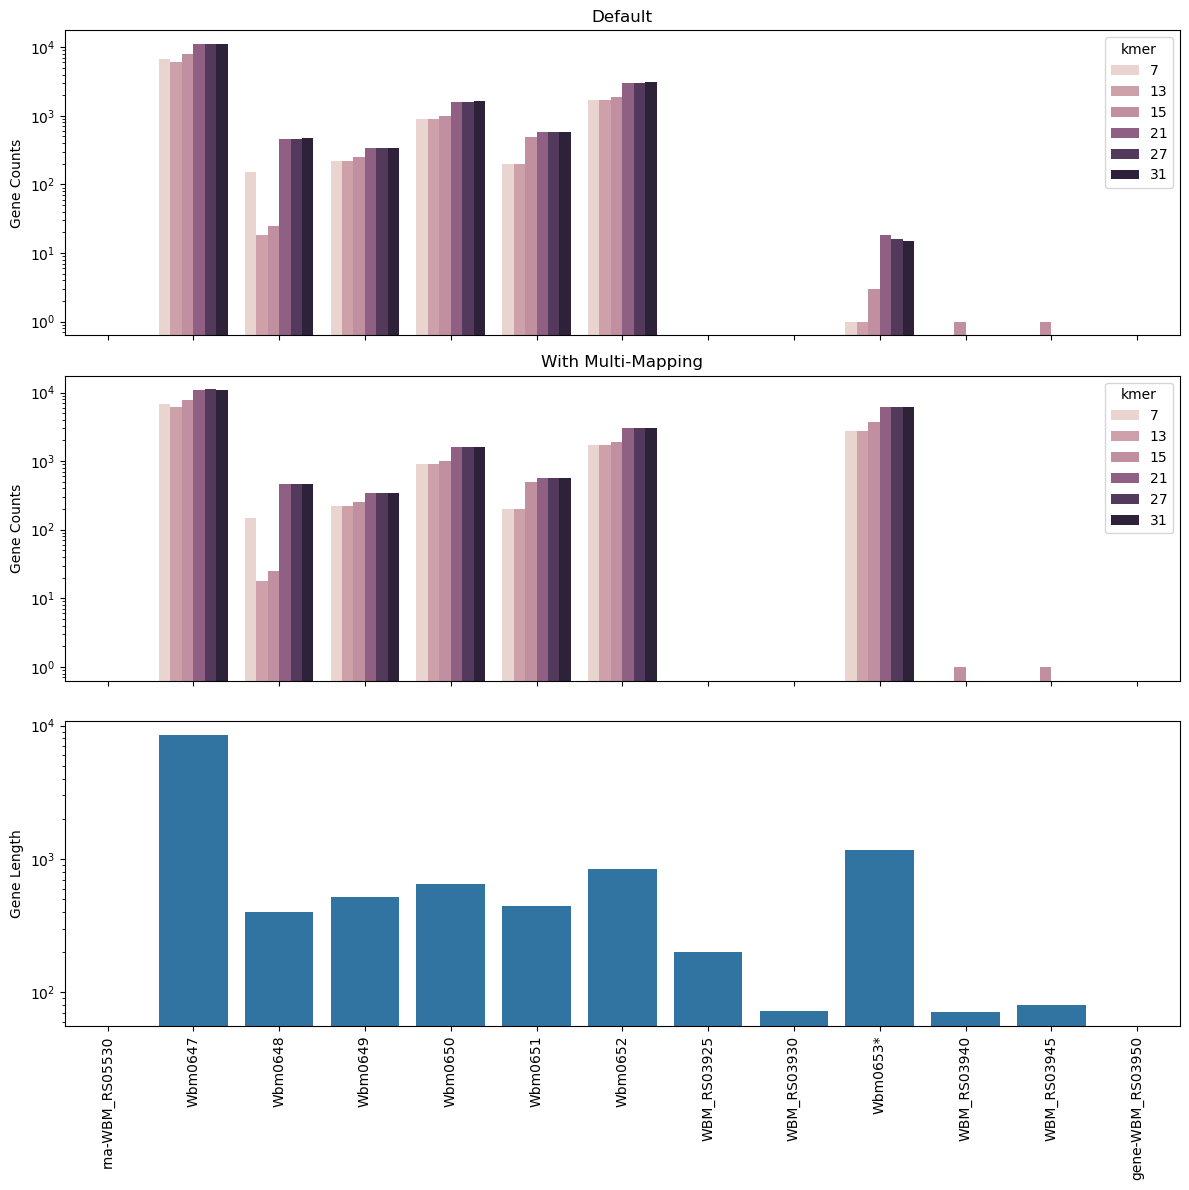

In [29]:
from matplotlib.colors import LogNorm
final_df = result_df.copy()
final_df['Gene Length Normalized Counts'] = final_df['counts'] / final_df['gene_length']
#final_df = final_df[final_df['source'] == 'default']
final_df['gene_name'] = pd.Categorical(final_df['gene_name'], final_order_list[::2])


fig, (ax1, ax3, ax2) = plt.subplots(3, 1, figsize=[12, 12], sharex=True)
sns.barplot(final_df[final_df['source'] == 'default'], x = 'gene_name', y = 'counts', hue = 'kmer',
            ax = ax1
           #annot_kws={'color':'black'}
           )
ax1.set_yscale('log')
ax1.set_ylabel('Gene Counts')
ax1.set_title('Default')

sns.barplot(final_df[final_df['source'] == 'mm'], x = 'gene_name', y = 'counts', hue = 'kmer',
            ax = ax3
           #annot_kws={'color':'black'}
           )
ax3.set_yscale('log')
ax3.set_ylabel('Gene Counts')
ax3.set_title('With Multi-Mapping')

#fig.suptitle('Different Kmer for Small Gene Detection (with multi-mapping)')
#plt.savefig('fadu_counts_norm.png', bbox_inches='tight')


sns.barplot(final_df[final_df['source'] == 'default'], x = 'gene_name', y = 'gene_length',
            ax = ax2
           #annot_kws={'color':'black'}
           )
ax2.set_yscale('log')
ax2.set_ylabel('Gene Length')
ax2.set_xlabel('')

plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()
#fig.savefig('figure5.png')